# Movie Classification

In this project, I will build a classification model that guesses whether a movie is a comedy or a thriller by using only the number of times chosen words appear in the movie's screenplay. This project involves several key steps and learning objectives that will help me understand and apply machine learning concepts in the context of text classification.

## Project Overview

The main goal of this project is to develop a k-nearest-neighbors (k-NN) classifier to predict the genre of a movie based on the frequency of certain words in its screenplay. By the end of this project, I will have learned how to:

1. **Build a k-nearest-neighbors classifier**: I will implement the k-NN algorithm, which is a simple and intuitive method used for classification and regression. The algorithm classifies a data point based on how its neighbors are classified.
2. **Test a classifier on data**: I will evaluate the performance of the classifier by testing it on a dataset and measuring its accuracy. This involves dividing the data into training and testing sets, training the model, and then assessing its performance on the test set.

## Steps Involved

1. **Data Preparation**: I will start by loading and preparing the dataset, which contains screenplays of movies labeled as either comedy or thriller. The data will be preprocessed to extract the relevant features (word frequencies) that will be used for classification.
2. **Feature Selection**: I will choose specific words that are likely to be good indicators of the movie's genre. These words will serve as the features for the classifier.
3. **Building the k-NN Classifier**: I will implement the k-nearest-neighbors algorithm, which involves calculating the distance between data points and determining the majority class among the nearest neighbors.
4. **Model Evaluation**: I will test the classifier on a separate test set to evaluate its performance. This includes calculating accuracy and possibly other metrics to understand how well the model performs.
5. **Hyperparameter Tuning**: I may experiment with different values of k (the number of neighbors) and other hyperparameters to find the best configuration for the classifier.
6. **Visualization**: I will create visualizations to help understand the data and the performance of the classifier. This might include plots of word frequencies, decision boundaries, and performance metrics.

## Learning Objectives

Through this project, I aim to:
- Understand the principles and workings of the k-nearest-neighbors algorithm.
- Gain experience in preprocessing and feature extraction from text data.
- Learn how to implement and test machine learning models.
- Develop skills in evaluating model performance and tuning hyperparameters.
- Enhance my ability to visualize data and interpret the results of machine learning algorithms.

By the end of this project, I will have a solid understanding of how to build and evaluate a k-nearest-neighbors classifier for text classification tasks. This foundational knowledge will be applicable to a wide range of problems in data science and machine learning.

To get started, I will load `datascience`, `numpy`, and `plots`.

In [1]:
import numpy as np
import math
import datascience
from datascience import *

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

## The Dataset

In this project, I am exploring movie screenplays to predict each movie's genre from the text of its screenplay. The dataset contains a list of 5,000 words that frequently occur in conversations between movie characters. For each movie, the dataset provides the frequency of each of these words in its screenplay. All words have been converted to lowercase to ensure consistency.

I will start by loading the `movies` table.

In [2]:
movies = Table.read_table('movies.csv')

Here is one row of the table and some of the frequencies of words that were said in the movie.

In [3]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*. The movie contains 4,895 words. The word "it" appears 115 times, making up approximately $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

### Bag-of-Words Representation

This numerical representation of a body of text, which describes only the frequencies of individual words, is called a bag-of-words representation. This model is often used in [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing). While a lot of information is discarded in this representation—such as the order of the words, the context of each word, who said what, the cast of characters, and actors—a bag-of-words representation is still useful. It retains a great deal of information and expresses it in a convenient and compact format.

In this project, I will investigate whether this representation is sufficient to build an accurate genre classifier. By focusing on the frequencies of words, I aim to determine if a simple bag-of-words model can effectively distinguish between comedies and thrillers based on their screenplays.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in the dataset have their titles lower-cased.* 

In [4]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title='toy story', Year='1995', Rating=8.1999999999999993, Genre='comedy', # Words=3016, she=0.0017427675148135001, decid=0.00034855350296270001, talk=0.0017427675148135001, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.00034855350296270001, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.00069710700592540001, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.0010456605088881, cigarett=0.0, jesu=0.0, mani=0.0, violin=0.0, financi=0.00034855350296270001, bai=0.0, cop=0.0, neighbor=0.0, cd=0.0, england=0.0, made=0.00034855350296270001, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0, waltz=0.0, behind=0.00034855350296270001, bourbon=0.0, favorit=0.00069710700592540001, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row.

In [5]:
row_for_title('toy story').item('fun') 

0.00034855350296270001

To determine the `expected_row_sum`, I need to consider the proportions in each row, excluding the first five columns. Since each row represents the frequency of words in a movie's screenplay, and these frequencies are converted to proportions, the sum of these proportions should equal 1 (or very close to 1 due to rounding errors) for each movie. This is because the proportions represent the fraction of the total word count accounted for by each of the 5,000 words.

I expect the sum of all proportions in each row (excluding the first five columns) to be approximately 1.

In [6]:
expected_row_sum = 1

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing inappropriate words, and converting the counts to frequencies), I created this new dataset containing the frequency of 5000 common words in each movie.

In [7]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


## Word Stemming

The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset. These words have been *stemmed*, or abbreviated heuristically, to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string. For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words I want to use, so a table called `vocab_table` is provided to see examples of unstemmed versions of each stemmed word. I will run the code below to load it. 

In [8]:
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


Using `vocab_table`, I find the stemmed version of the word "elements" and assign the value to `stemmed_message`.


In [9]:
stemmed_message = vocab_table.where("Word", "elements").column("Stem").item(0)
stemmed_message

'element'

I will determine which stem in the dataset has the most words that are shortened to it and assign `most_stem` to that stem.

In [10]:
most_stem =  vocab_table.group("Stem").sort("count", descending=True).column("Stem").item(0)
most_stem

'gener'

I will determine the longest word in the dataset whose stem wasn't shortened and assign that to `longest_uncut`. If there are ties, I will break them alphabetically from Z to A.

In [11]:
tbl_with_lens = vocab_table.with_columns("Stem Length", vocab_table.apply(len,"Stem"), "Word Length", vocab_table.apply(len, "Word"))
tbl_with_diff = tbl_with_lens.with_column("Difference", tbl_with_lens.column("Stem Length") - tbl_with_lens.column("Word Length"))

longest_uncut = tbl_with_diff.where("Difference", are.equal_to(0)).where("Word Length", max(tbl_with_diff.where("Difference", are.equal_to(0)).column("Word Length"))).sort("Word", descending=True).column("Word").item(0)
longest_uncut

'misunderstand'

I will determine how many stems have only one word that is shortened to them and assign `count_single_stems` to that count.

In [12]:
count_single_stems = vocab_table.group("Stem").where("count",1).num_rows
count_single_stems

1408

## Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, I’ll use the associated proportions to investigate the relationship between different words.

The first association I'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space".

As usual, I'll investigate our data visually before performing any numerical analysis.

I will run the cell below to plot a scatter diagram of "space" proportions vs "outer" proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

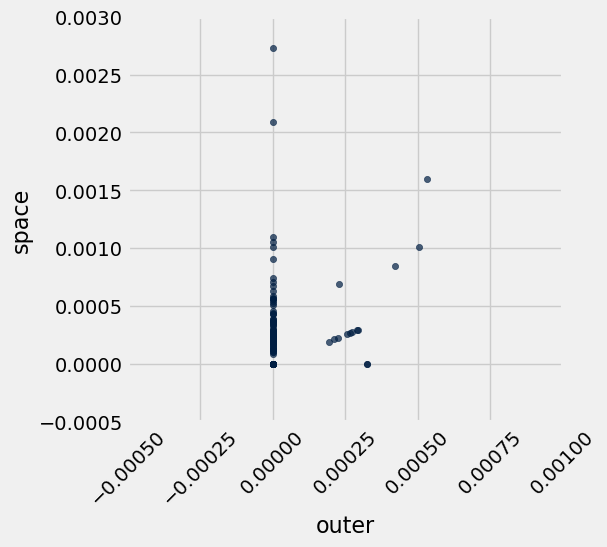

In [13]:
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

Looking at the scatter plot, it is difficult to see if there is an association. I will calculate the correlation coefficient for the potential linear association between the proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

In [14]:
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.mean(outer))/np.std(outer)
space_su = (space - np.mean(space))/np.std(space)

outer_space_r = np.mean(outer_su*space_su)
outer_space_r

0.31942607876895912

I will choose two different words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. I will calculate the correct values for `r`, `slope`, and `intercept`.

Let's choose the words "love" and "happy" as they are often mentioned together.

First, I'll calculate the correlation coefficient `r`:

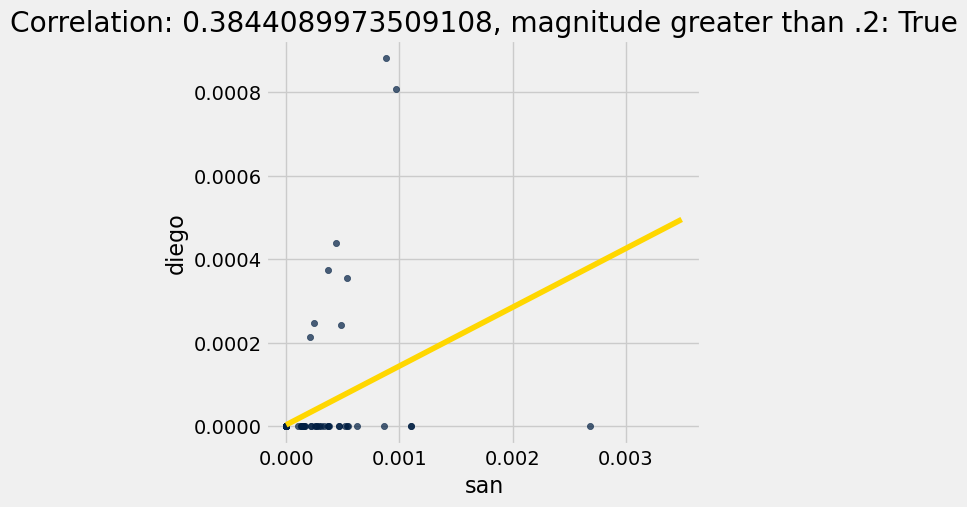

In [15]:
word_x = 'san'
word_y = 'diego'

arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.mean(arr_x))/np.std(arr_x)
y_su = (arr_y - np.mean(arr_y))/np.std(arr_y)

r = np.mean(x_su * y_su)

slope = r * (np.std(arr_y) / np.std(arr_x))
intercept = np.mean(arr_y) - slope * np.mean(arr_x)

movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

Imagine that I picked the words "san" and "francisco" as the two words that I would expect to be correlated because they compose the city name San Francisco. 

**Note:** "San" can also precede other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," which would reduce the correlation between "san" and "francisco."

## Splitting the Dataset

Now, I'm going to use our `movies` dataset for two purposes:

1. First, I want to *train* movie genre classifiers.
2. Second, I want to *test* the performance of our classifiers. 

Hence, I need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help me determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, I must ensure that there are no movies that appear in both sets. I will do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split. I just take the first 85% of the dataset for training and the rest for testing.

I will run the code below to separate the datasets into two tables.

In [16]:
training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


I will draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`). The two bars should be labeled "Training" and "Test". First, I will complete the function `comedy_proportion` to help create the bar chart.

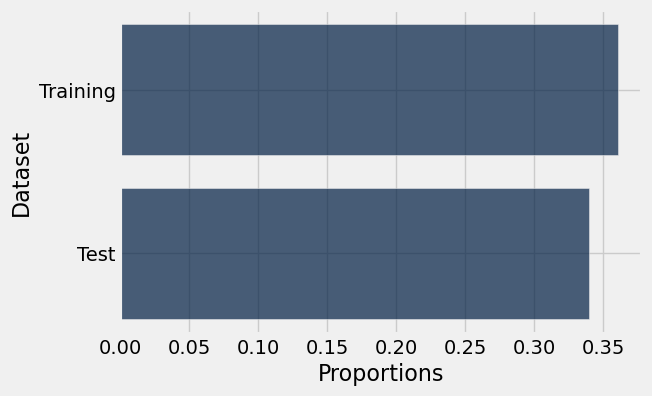

In [17]:
def comedy_proportion(table):
    return table.where('Genre', 'comedy').num_rows / table.num_rows

proportions = make_array(comedy_proportion(train_movies),comedy_proportion(test_movies))
proportion = Table().with_columns('Dataset', make_array('Training', 'Test'), 'Proportions', proportions)

proportion.barh('Dataset')

## K-Nearest Neighbors

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm. Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) I have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller. The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, I will visualize the algorithm instead of just describing it.

## Classifying a Movie

In k-NN, I classify a movie by finding the `k` movies in the *training set* that are most similar according to the features I choose. We call those movies with similar features the *nearest neighbors*. The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie. The features we will use are the proportions of the words "water" and "feel" in the movie. Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, I need to make our notion of similarity more precise. I will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram.

**This distance is called the Euclidean distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$**.

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel". Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$. (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to *The Godfather* based on these features, which makes sense as both movies are comedies, while *The Godfather* is a thriller.

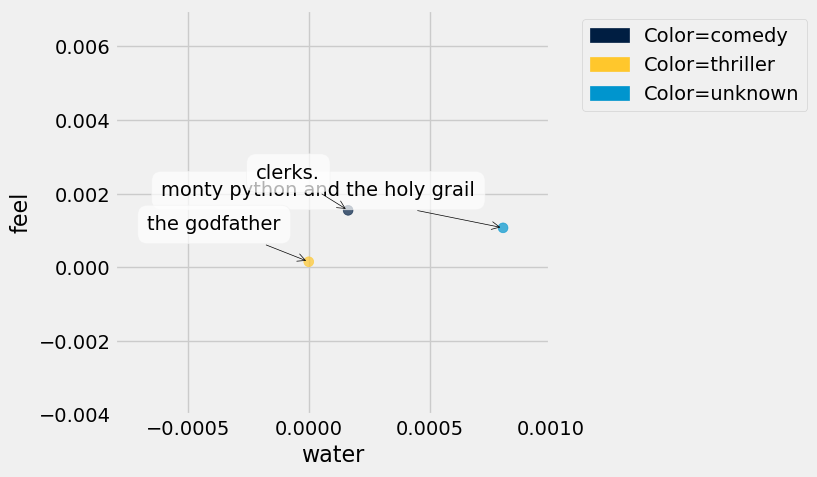

In [18]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

I will compute the Euclidean distance between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only. I will assign it the name `one_distance`.

In [19]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

one_distance = np.sqrt((python.item("water")-godfather.item("water"))**2 + (python.item("feel")-godfather.item("feel"))**2)
one_distance

0.0012225209151294461

Below, I've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

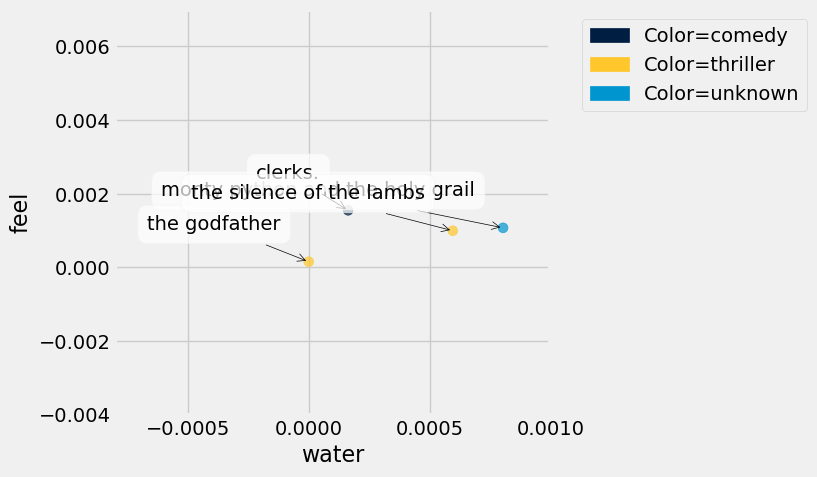

In [20]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

I will complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call my function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*.

In [21]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Computing the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return np.sqrt((row0.item(x_feature)-row1.item(x_feature))**2 + (row0.item(y_feature)-row1.item(y_feature))**2)

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.000798381068723
the silence of the lambs distance:	 0.000222563148556


I will define the function `distance_from_python` so that it works as described.

In [22]:
def distance_from_python(title):
    """Return the distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    return distance_two_features("monty python and the holy grail", title,"water","feel")

# Calculating the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.00079838106872277164

Using the features `"water"` and `"feel"`, I will find the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*. I will make a **table** named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*. The table will be **sorted in ascending order by `"distance from python"`**.

Smaller distances from *Monty Python and the Holy Grail* are more helpful in helping us classify the movie because they indicate greater similarity in the features used for classification.

In [23]:

new = train_movies.select("Title", "Genre", "water", "feel")
new_table = new.with_columns("distance from python",
                                            new.apply(distance_from_python,
                                                           "Title")).sort('distance from python')
close_movies = new_table.take(make_array(0,1,2,3,4))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


Next, I'll classify *Monty Python and the Holy Grail* based on the genres of the closest movies.

To do so, I'll define the function `most_common` so that it works as described in its documentation below.

In [24]:
def most_common(label, table):
    """This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    return table.group(label).sort("count", descending=True).column(0).item(0)

# Calling most_common on my table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

## Features

Now, I am going to extend my classifier to consider more than two features at a time to see if I can get a better classification of our movies.

Euclidean distance still makes sense with more than two features. For `n` different features, I compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

I will write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length.

Next, I will use the function I just defined to compute the distance **between the first and second movie** in the **training set** *using all of the features*.

In [25]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sqrt(np.sum((features_array1 - features_array2)**2))

array_values_movie_1  = np.array(train_movies.drop(np.arange(0,5)).row(0))
array_values_movie_2 = np.array(train_movies.drop(np.arange(0,5)).row(1))
distance_first_to_second = distance(array_values_movie_1,array_values_movie_2)
distance_first_to_second

0.033354468908813169

## Feature Engineering

Unfortunately, using all of the features has some downsides. One clear downside is the lack of *computational efficiency*—computing Euclidean distances just takes a long time when we have lots of features.

So I'm going to select just 20 features. I'd like to choose features that are very *discriminative*. That is, features which lead me to correctly classify as much of the test set as possible.

The plot below shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in a thriller movie on the vertical axis.

![alt text](word_plot.png "Title")

Words in the bottom left corner of the plot are uncommon in both comedy and thriller movies. Words in the top right corner of the plot are common in comedy movies and common in thriller movies. If I see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, a reasonable guess about the genre of the movie would be that it is a comedy movie.


Using the plot above, I will make an array of at least 10 common words that I think might let me **distinguish** between comedy and thriller movies. I will ensure to choose words that are **frequent enough** that every movie contains at least one of them, but not just the most frequent words.

In [26]:
my_features = make_array('dead', 'kill', 'murder', 'detect', 'gun', 'cop', 'mean', 'killer', 'price', 'nice')

train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

I attemped to select the features that were fairly uncommon and at the bottom left but not so close to the bottom end either so that the words had a higher frequency in the thriller movies as it is hard to generalize words that are common in comedy movies. Words such as 'kill' or 'murder' are more specific to the genre of thrillers and allow me to distinguish between the two. 

Next, I'll classify the first movie from the test set using the selected features. I can examine the movie by running the cells below to determine if it will be classified correctly.

In [27]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


dead,kill,murder,detect,gun,cop,mean,killer,price,nice
0.000164853,0.000329707,0.000164853,0,0,0,0.00098912,0,0,0.00098912


As before, I want to look for the movies in the training set that are most like our test movie. I will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set. While I could do this with a `for` loop, to make it computationally faster, I will use the provided function `fast_distances`.

In [28]:
def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

I will use the `fast_distances` function provided above to compute the distance from the first movie in my test set to all the movies in my training set, **using my set of features**. I will then make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

I will ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

In [29]:
fast_test = fast_distances(test_my_features.row(0), train_my_features)
genre_and_distances = Table().with_columns('Genre', train_movies.column('Genre'),
                                         'Distance',fast_test).sort('Distance')
genre_and_distances

Genre,Distance
comedy,0.000247096
thriller,0.000394232
comedy,0.000434743
comedy,0.000445387
comedy,0.000484847
comedy,0.000510095
thriller,0.000599855
comedy,0.000615573
comedy,0.000640551
comedy,0.00066603


Now I will compute the 7-nearest neighbors classification of the first movie in the test set. I will decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances I've calculated. Then I will check whether my classifier chose the right genre.

In [30]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances.take(np.arange(0,7)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = True

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, comedy, was correct.


## A classifier function

Now I can write a single function that encapsulates the whole process of classification.

I will write a function called `classify`. It will take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class (the string `'comedy'` or the string `'thriller'`) a `k`-nearest neighbor classifier picks for the given row of features.

In [31]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = Table().with_columns('Genre', train_labels, 'Distance', distances).sort('Distance')
    return most_common('Genre', genre_and_distances.take(np.arange(0,k)))

I will assign `godzilla_genre` to the genre predicted by my classifier for the movie "Godzilla" in the test set, using **15 neighbors** and using my 10 features.

In [32]:
godzilla_features = test_movies.where('Title', 'godzilla').select(my_features).row(0)
godzilla_genre = classify(godzilla_features, train_my_features, train_movies.column('Genre'), 15)
godzilla_genre

'comedy'

Finally, when I evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

I will create a classification function that takes as its argument a row containing my 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set.

In [33]:
def classify_feature_row(row):
    features = classify(row, train_my_features, train_movies.column('Genre'), 15)
    return features

classify_feature_row(test_my_features.row(0))

'comedy'

## Evaluating my classifier

I will use `classify_with_15_neighbors` and `apply` to classify every movie in the test set. I will assign these guesses as an array to `test_guesses`. Then, I will compute the proportion of correct classifications.

In [34]:
test_guesses = test_movies.select(my_features).apply(classify_feature_row)
proportion_correct = sum(test_guesses == test_movies.column('Genre')) / test_movies.num_rows
proportion_correct

0.71999999999999997

I will assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The `'Genre'` column will contain the original genres, not the ones I predicted. The `'Was correct'` column will contain `True` or `False` depending on whether or not the movie was classified correctly.

In [35]:
test_movie_correctness = Table().with_columns('Title', test_movies.column('Title'),'Genre', test_movies.column('Genre'),'Was correct', test_guesses == test_movies.column('Genre'))
test_movie_correctness.sort('Was correct', descending = True).show(5)

Title,Genre,Was correct
ghostbusters ii,comedy,True
intolerable cruelty,comedy,True
book of shadows: blair witch 2,thriller,True
broadcast news,comedy,True
mission: impossible,thriller,True


Upon reviewing the misclassified movies, it seems that the classifier tends to struggle with movies that blend elements of both comedy and thriller genres or have ambiguous content. For example, movies with dark humor or thriller-comedy elements may confuse the classifier, leading to incorrect predictions. Additionally, some movies may have misleading word frequencies that do not align well with the typical features of their genre.

In [36]:
test_movie_correctness.where('Was correct', False).show(14)

Title,Genre,Was correct
psycho,thriller,False
the getaway,thriller,False
the atomic submarine,thriller,False
the adventures of buckaroo banzai across the 8th dimension,comedy,False
signs,thriller,False
jennifer eight,thriller,False
spider-man,thriller,False
the exorcist,thriller,False
beetle juice,comedy,False
new nightmare,thriller,False


With the movies that were misclassified, I noticed a trend where the movies either had slightly ambiguous genre listings or held multiple genres. I chose words that would be more specific to horror movies, but many of the misclassified movies were comedies or films of other genres that contained horror elements in their subject matter. Most of the misclassified films also happened to be thriller movies with more action or psychological elements, and the words I chose, such as 'killed' and 'cop', might have contributed to the misclassifications.

## Conclusion

At this point, I've gone through one cycle of classifier design. Let's summarize the steps:

1. **From available data, select test and training sets:**
   - I started by splitting the dataset into training and test sets to ensure that my classifier would be evaluated on unseen data.
   
2. **Choose an algorithm you're going to use for k-NN classification:**
   - I chose the k-nearest neighbors (k-NN) algorithm for its simplicity and effectiveness in classification tasks.

3. **Identify some features:**
   - I identified a set of features (word frequencies) that I believed would help distinguish between comedy and thriller movies. This process involved analyzing word usage patterns and selecting words that were common in one genre but not the other.

4. **Define a classifier function using your features and the training set:**
   - I implemented the k-NN algorithm in a function that takes a test movie and classifies it based on its nearest neighbors in the training set. This function used the Euclidean distance to measure similarity between movies.

5. **Evaluate its performance (the proportion of correct classifications) on the test set:**
   - I tested the classifier on the test set and calculated the proportion of correct classifications. This evaluation helped me understand the effectiveness of my feature selection and the overall performance of the classifier.

### Key Findings
- **Feature Selection:** The choice of features plays a crucial role in the performance of the classifier. Words that were chosen for their discriminative power significantly impacted the accuracy of the predictions.
- **Misclassifications:** Many of the misclassified movies had ambiguous genre listings or contained elements of multiple genres. This highlights the challenge of classifying movies with mixed or unclear genre characteristics.
- **Classifier Performance:** The overall performance of the classifier was evaluated by the proportion of correct classifications. While the classifier performed well on clear-cut cases, it struggled with movies that blended genres or had less distinctive word usage patterns.

### Improving the Classifier
To further improve the classifier, I could:
- **Refine Feature Selection:** Experiment with different sets of features or increase the number of features to capture more nuanced differences between genres.
- **Advanced Algorithms:** Explore more advanced classification algorithms that might handle mixed-genre movies better.
- **Additional Data:** Incorporate more data or metadata (such as movie summaries or reviews) to provide additional context for classification.

Overall, this project provided valuable insights into the process of designing and evaluating a classifier. By understanding the strengths and limitations of the k-NN algorithm and the importance of feature selection, I am better equipped to tackle similar classification tasks in the future.
